In [1]:
%%capture --no-display
!pip install opencv-python

In [2]:
import os
import numpy as np
from PIL import Image
import re
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

In [3]:
# seperate paths
folders = [132]

# Group tiles and masks by patient
patient_data = {folder: {'tiles': [], 'masks': []} for folder in folders}

for folder in folders:
    dataset_path = os.path.join("..", "..", "..", "..", "data", "UNet_Data_Bigger", str(folder))
    for file in sorted(os.listdir(dataset_path)):
        if "mask" in file:
            patient_data[folder]['masks'].append(os.path.join(dataset_path,file))
        elif "tile" in file:
            patient_data[folder]['tiles'].append(os.path.join(dataset_path,file))

In [5]:
patient_data[132]['tiles'][0:2]

['../../../../data/UNet_Data_Bigger/132/510_0_tile_True_False_False_False_False.png',
 '../../../../data/UNet_Data_Bigger/132/510_100_tile_True_False_False_False_False.png']

In [6]:
patient_data[132]['masks'][0:8]

['../../../../data/UNet_Data_Bigger/132/510_0_mask_grade3.png',
 '../../../../data/UNet_Data_Bigger/132/510_0_mask_grade4cg.png',
 '../../../../data/UNet_Data_Bigger/132/510_0_mask_grade4fg.png',
 '../../../../data/UNet_Data_Bigger/132/510_0_mask_grade5.png',
 '../../../../data/UNet_Data_Bigger/132/510_100_mask_grade3.png',
 '../../../../data/UNet_Data_Bigger/132/510_100_mask_grade4cg.png',
 '../../../../data/UNet_Data_Bigger/132/510_100_mask_grade4fg.png',
 '../../../../data/UNet_Data_Bigger/132/510_100_mask_grade5.png']

Put combined masks in combined_masks folder

In [7]:
# will need to do this for all folders
for folder in tqdm(folders, position=0, leave=True):
    mask_paths = patient_data[folder]['masks']
    for index in tqdm(range(len(patient_data[folder]['tiles'])), position=0, leave=True):

        # when tile doesn't contain cancer, skip 80% of the time
        tile_str = patient_data[folder]['tiles'][index]
        if "True" not in tile_str and random.random() < 0.8:
            continue

        mask_index = index*4
        masks = []
        match = ""
        for mask_path in mask_paths[mask_index:mask_index+4]:
            masks.append(Image.open(mask_path).convert("L"))
            pattern = r"(\d+_\d+)"
            match = re.findall(pattern, mask_path)[0]

        split = match.split("_")
        image_id = split[0]
        tile_id = split[1]

        # combine masks into one
        mask1 = np.array(masks[0], dtype=int)
        mask2 = np.array(masks[1], dtype=int)
        mask3 = np.array(masks[2], dtype=int)
        mask4 = np.array(masks[3], dtype=int)

        # map masks to class indicies
        mask1[mask1!=0] = 1
        mask2[mask2!=0] = 2
        mask3[mask3!=0] = 3
        mask4[mask4!=0] = 4

        # Combine masks, giving priority to higher values
        combined_mask = np.maximum(mask1, mask2)
        combined_mask = np.maximum(combined_mask, mask3)
        combined_mask = np.maximum(combined_mask, mask4)

        # see what cancers are present
        contains_g3 = np.any(combined_mask == 1)
        contains_g4fg = np.any(combined_mask == 2)
        contains_g4cg = np.any(combined_mask == 3)
        contains_g5 = np.any(combined_mask == 4)

        # Resize the mask to 512x512 using OpenCV
        resized_mask = cv2.resize(combined_mask, (512, 512), interpolation=cv2.INTER_NEAREST)

        # need to flip vertically
        flipped_mask = np.flipud(resized_mask)

        im = Image.fromarray(flipped_mask)
        #im.save(f"../../../../data/UNet_Data_Bigger/test/{folder}_{image_id}_{tile_id}_mask_{contains_g3}_{contains_g4fg}_{contains_g4cg}_{contains_g5}.png")
        im.save(f"../../../../data/UNet_Data_Bigger/combined_masks_fixed/{folder}_{image_id}_{tile_id}_mask_{contains_g3}_{contains_g4fg}_{contains_g4cg}_{contains_g5}.png")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2244 [00:00<?, ?it/s]

Examine one example image

In [8]:
def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image) # dividing by 255 because default float display is [0,1]
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    normalized_mask = mask
    plt.imshow(normalized_mask)
    plt.axis('off')

    plt.show()

In [9]:
def overlay(image, mask):
    # Convert image and mask to numpy arrays
    image_np = np.array(image)
    mask_np = np.array(mask)

    # Ensure mask is a single channel
    if mask_np.ndim == 3:
        mask_np = mask_np[..., 0]  # Take only one channel if it has multiple

    # Define color mapping for mask values 0-4
    colors = {
        0: [0, 0, 0],      # Black (no mask)
        1: [48, 255, 50],    # Grade 3
        2: [254, 22, 255],    # Grade 4 CG
        3: [255, 250, 20],    # Grade 4 FG
        4: [33, 255, 255],  # Grade 5
    }

    # Create an empty RGB mask (3 channels)
    mask_rgb = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Apply the color mapping to create the RGB mask
    for value, color in colors.items():
        mask_rgb[mask_np == value] = color

    # Overlay the mask on the image with some transparency
    alpha = 0.5  # Transparency factor
    overlay = np.where(mask_rgb.any(axis=-1, keepdims=True),
                       alpha * mask_rgb + (1 - alpha) * image_np[..., :3],
                       image_np[..., :3]).astype(np.uint8)

    # Display the result
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Image with Mask Overlay')
    plt.show()

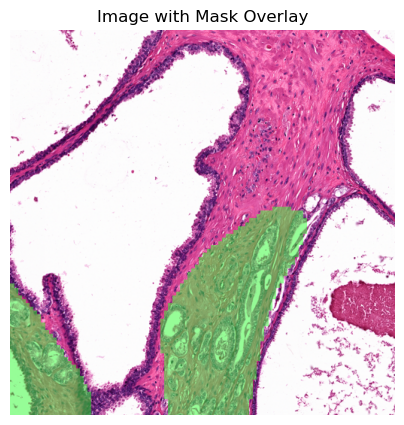

In [11]:
image_path = "../../../data/UNet_Data_Bigger/134/1359_10_tile_True_False_False_False_False.png"
mask_path = "../../../data/UNet_Data_Bigger/test/134_1359_10_mask_True_False_False_False.png"

# Open an image file
image = Image.open(image_path)
mask = Image.open(mask_path)

overlay(image, mask)

Check if image is background

In [33]:
def isBackground(tile):
    # Convert the PIL image to a NumPy array
    tile_np = np.array(tile)
    
    hsv = cv2.cvtColor(tile_np, cv2.COLOR_RGB2HSV)

    lower = np.array([0,10,0])
    upper = np.array([255,255,255])

    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(tile_np, tile_np, mask = mask)

    # is background if less than 75000 non-white pixels
    if (np.count_nonzero(res) < 75000):
        return True

    return False

In [34]:
isBackground(image)

False

Examine multiple images

In [130]:
# Note: the T/F order of FG and CG are flipped :(
def flip(path):
    # Regular expression to match the pattern and extract the True/False values
    pattern = r'(_True|_False)+(?=\.png$)'
    match = re.search(pattern, path)

    if match:
        # Extract the matched True/False substring
        true_false_str = match.group(0)

        # Split the substring into individual parts
        parts = true_false_str.split('_')

        # Filter out empty strings
        parts = [part for part in parts if part]

        if len(parts) >= 4:
            # Switch the center two values
            parts[1], parts[2] = parts[2], parts[1]

        # Reconstruct the True/False substring
        new_true_false_str = '_' + '_'.join(parts)

        # Replace the original True/False substring with the new one
        new_path = path[:match.start(0)] + new_true_false_str + path[match.end(0):]
        return new_path

In [ ]:
folder = 116
number = 10
dataset_path = os.path.join("..", "..", "..", "..", "data", "UNet_Data_Bigger", str(folder))
for image_path in sorted(os.listdir(dataset_path)):
    # only do tiles:
    if "tile" in image_path:
        # Extract the filename
        filename = os.path.basename(image_path)

        # Remove the last '_False' from the filename
        new_filename = re.sub(r'_False(?=\.png$)', '', filename)
        new_filename = new_filename.replace("tile", "mask")
        flipped_filename = flip(new_filename)

        mask_path = os.path.join("..", "..", "..", "..", "data", "UNet_Data_Bigger", "combined_masks_fixed", f"{folder}_"+flipped_filename)

        print(image_path)

        # Open an image file
        image = Image.open(os.path.join(dataset_path, image_path))
        mask = Image.open(mask_path)

        overlay(image, mask)

        number -= 1
        if number < 0:
            break